In [1]:
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt

from torch import optim, nn
from modules.dataset import *
from modules.network import *
from modules.embeddings import *
from torch import save, device, cuda
from torch.utils.data import DataLoader

In [2]:
device = device("cuda") if cuda.is_available() else device("cpu")
print('Selected device:', device)

Selected device: cpu


In [3]:
# Set local paths
images_path = "./images"
res_path = "./data/losses"

# Dataset

## Loading and preprocessing

In [4]:
#%%Loading the dataset 

min_len = 10
dataset = Bible('./data/bible.txt', min_len = min_len)

    
len(dataset)

28095

In [5]:
# Check if every sentence begins with two ":"
i, j = 0, 0
for sentence in dataset:
    if sentence[0] == ':' and  sentence[1] == ':':
        i += 1
    elif sentence[0] == ':' or  sentence[1] == ':':
        j += 1
i == len(dataset)

False

In [6]:
len(dataset) - i

28095

In [7]:
j

25530

Mean sentence length: 28.137996084712583
Max sentence length: 103
Min sentence length: 10


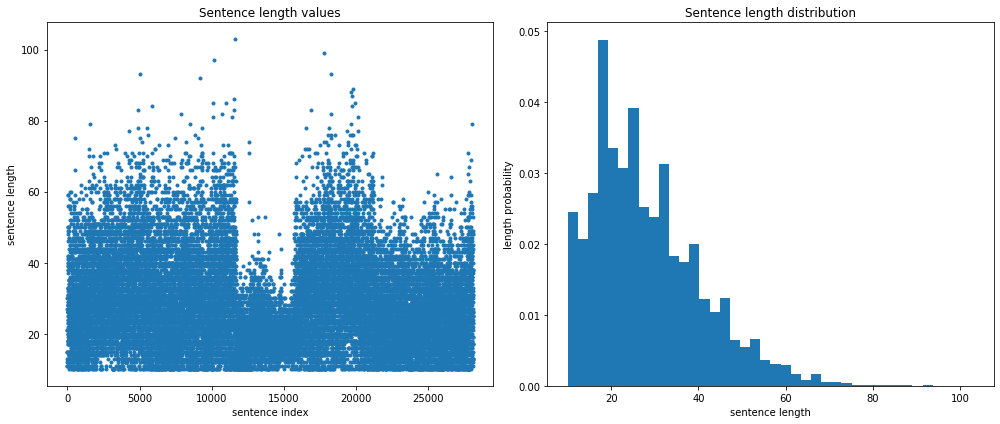

In [8]:
# Dataset visualization
lengths = [ len(sentence)  for sentence in dataset ]
fig, axs = plt.subplots(1, 2, figsize=(14,6))
axs.ravel()
axs[0].set_title('Sentence length values')
axs[0].set_xlabel('sentence index')
axs[0].set_ylabel('sentence length')
_ = axs[0].plot(lengths, '.')
axs[1].set_title('Sentence length distribution')
axs[1].set_xlabel('sentence length')
axs[1].set_ylabel('length probability')
_ = axs[1].hist(lengths, bins=40, density=True)

print('Mean sentence length:', np.mean(lengths))
print('Max sentence length:', np.max(lengths))
print('Min sentence length:', np.min(lengths))

plt.tight_layout()
plt.savefig(images_path+f'/bible_{min_len}.png')
plt.show()

In [9]:
print(len(dataset.words))

790537


## Word embeddings

In [10]:
# Define the embedding dimension
embedding_dim = 50

# Copy dataset words
words = set(dataset.words.copy())

In [11]:
# Load embeddings
with open('./data/embeddings_bible', 'rb') as f:
    embeddings = pickle.load(f)

# Get list of words
words = [*embeddings.keys()]
# Get vectors as float tensor
vectors = torch.tensor([*embeddings.values()], dtype=torch.float)

In [12]:
crop_len = 8

# Define transformation 
dataset.transform = transforms.Compose([
    RandomCrop(crop_len),
    WordToVector(words),
    ToTensor()
])

In [13]:
# Defined the transform, this call returns the word index (after random cropping)
dataset[0].shape

torch.Size([8])

# LSTM

In [14]:
##Parameters

params = {
        # network
        'hidden_units' : 2**6, # symmetric layers
        'layers_num' : 2,
        'dropout_prob' : 0.4,

        # training
        'batch_size' : 2000,
        'num_epochs' : 1000,

        # optimizer
        'lr' : 1e-2,
        'wd' : 1e-3,
    
        # dataset
        'crop_len' : crop_len,
        'min_len' : min_len
        }

# save
out_dir = f'LSTM_{crop_len}_{min_len}_bible'+'_{}_{}'.format(params['lr'],params['wd'])

In [15]:
# Split initial dataset in train dataset and test dataset
train_dataset, test_dataset = split_train_test(dataset, 0.9)
# Make train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
# Make test dataloader
test_dataloader = DataLoader(test_dataset, shuffle=False)

In [16]:
#TODO: hyperparameter optimization, this part must be included in the GridSearch iteration

#%% Initialize network
net = Network(vocab_size = vectors.shape[0],
              embedding_dim = embedding_dim,
              hidden_units = params['hidden_units'],
              layers_num = params['layers_num'],
              hidden_type = 'LSTM',
              trained_embeddings = vectors,
              dropout_prob = params['dropout_prob']
             )

# Define optimizer
optimizer = optim.Adam(net.parameters(), lr=params['lr'], weight_decay=params['wd'])
# Define loss function
loss_fn = nn.MSELoss()
# loss_fn = nn.NLLLoss()

net.to(device)

Network(
  (rnn): LSTM(50, 64, num_layers=2, batch_first=True, dropout=0.4)
  (out): Linear(in_features=64, out_features=50, bias=True)
  (embed): Embedding(11540, 50)
)

In [17]:
%%time

#%% Train network

# Define losses containers
train_loss_epochs = []
val_loss_epochs = []

for epoch in range(params['num_epochs']):
    print('\n\n EPOCH %d/%d' % (epoch + 1, params['num_epochs']))
    
    # Set training mode
    net.train()
    # Define losses container for one epoch
    train_loss_log = []
    
    # Iterate batches
    for batch_sample in train_dataloader:
        # Extract batch
        batch = batch_sample.long().to(device)
        # Update network
        batch_loss = net.train_batch(batch, loss_fn, optimizer)
        train_loss_log.append(batch_loss)
        # print('\t Training loss (single batch):', batch_loss)
        
    print('\t Training loss (epoch - mean): ', np.mean(train_loss_log) )
    train_loss_epochs.append(np.mean(train_loss_log))
    
    # Set evaluation mode
    net.eval()
    val_loss_log = []
    with torch.no_grad():
        for batch_sample in test_dataloader:
            batch = batch_sample.long().to(device)
            val_loss = net.test_batch(batch, loss_fn)
            val_loss_log.append(val_loss)
            
        print('\t Validation loss (epoch - mean):', np.mean(val_loss_log))
        val_loss_epochs.append(np.mean(val_loss_log))
        
    # Early stopping
    # if epoch>200 and abs(val_loss_epochs[-1] - val_loss_epochs[-200]) < 1e-10:
    #    break
    
losses = { 'train': train_loss_epochs, 'val':  val_loss_epochs, 'params' : params }

# Save losses dictionary
with open(res_path + "/" + out_dir, 'wb') as f:
    pickle.dump(losses, f, pickle.HIGHEST_PROTOCOL)



 EPOCH 1/1000
	 Training loss (epoch - mean):  0.26990782756071824
	 Validation loss (epoch - mean): 0.17987973162497903


 EPOCH 2/1000
	 Training loss (epoch - mean):  0.15217213791150314
	 Validation loss (epoch - mean): 0.1292629676233432


 EPOCH 3/1000
	 Training loss (epoch - mean):  0.11450392007827759
	 Validation loss (epoch - mean): 0.09850158194632357


 EPOCH 4/1000
	 Training loss (epoch - mean):  0.08781035932210776
	 Validation loss (epoch - mean): 0.07783834273595695


 EPOCH 5/1000
	 Training loss (epoch - mean):  0.06901723518967628
	 Validation loss (epoch - mean): 0.062303726743553965


 EPOCH 6/1000
	 Training loss (epoch - mean):  0.056550838626348056
	 Validation loss (epoch - mean): 0.051083840168521855


 EPOCH 7/1000
	 Training loss (epoch - mean):  0.04664870150960409
	 Validation loss (epoch - mean): 0.0431812727988302


 EPOCH 8/1000
	 Training loss (epoch - mean):  0.04043183905573992
	 Validation loss (epoch - mean): 0.03619692456762145


 EPOCH 9/1000

	 Training loss (epoch - mean):  1.4213470841731088e-05
	 Validation loss (epoch - mean): 1.2535575043402518e-05


 EPOCH 67/1000
	 Training loss (epoch - mean):  1.16376191866808e-05
	 Validation loss (epoch - mean): 1.0374834082028923e-05


 EPOCH 68/1000
	 Training loss (epoch - mean):  9.548811249260325e-06
	 Validation loss (epoch - mean): 8.70907568869344e-06


 EPOCH 69/1000
	 Training loss (epoch - mean):  7.849829811535668e-06
	 Validation loss (epoch - mean): 7.299839239339563e-06


 EPOCH 70/1000
	 Training loss (epoch - mean):  6.444330000914096e-06
	 Validation loss (epoch - mean): 5.651248042980502e-06


 EPOCH 71/1000
	 Training loss (epoch - mean):  5.210142822201865e-06
	 Validation loss (epoch - mean): 4.704093291195849e-06


 EPOCH 72/1000
	 Training loss (epoch - mean):  4.155332100288853e-06
	 Validation loss (epoch - mean): 3.7527214105706914e-06


 EPOCH 73/1000
	 Training loss (epoch - mean):  3.4247637953600274e-06
	 Validation loss (epoch - mean): 2.9238402251

	 Training loss (epoch - mean):  7.690541539599856e-11
	 Validation loss (epoch - mean): 1.0298158203672391e-10


 EPOCH 131/1000
	 Training loss (epoch - mean):  8.582348720587163e-11
	 Validation loss (epoch - mean): 5.4713852223342725e-11


 EPOCH 132/1000
	 Training loss (epoch - mean):  8.959215794459915e-11
	 Validation loss (epoch - mean): 4.656150047232572e-11


 EPOCH 133/1000
	 Training loss (epoch - mean):  1.0156141979761762e-10
	 Validation loss (epoch - mean): 7.878473784088702e-11


 EPOCH 134/1000
	 Training loss (epoch - mean):  9.062952872148558e-11
	 Validation loss (epoch - mean): 7.570825196260649e-11


 EPOCH 135/1000
	 Training loss (epoch - mean):  7.654419299251404e-11
	 Validation loss (epoch - mean): 5.7799250769491256e-11


 EPOCH 136/1000
	 Training loss (epoch - mean):  9.4196696650049e-11
	 Validation loss (epoch - mean): 1.5094146733149046e-10


 EPOCH 137/1000
	 Training loss (epoch - mean):  7.23734423085931e-11
	 Validation loss (epoch - mean): 8.5152

	 Training loss (epoch - mean):  2.5941119658351014e-10
	 Validation loss (epoch - mean): 1.9956486599947798e-10


 EPOCH 194/1000
	 Training loss (epoch - mean):  2.921801219771899e-10
	 Validation loss (epoch - mean): 3.140922706561695e-10


 EPOCH 195/1000
	 Training loss (epoch - mean):  3.1798335332366123e-10
	 Validation loss (epoch - mean): 2.415861373503209e-10


 EPOCH 196/1000
	 Training loss (epoch - mean):  2.349771734026891e-10
	 Validation loss (epoch - mean): 2.0484589710869696e-10


 EPOCH 197/1000
	 Training loss (epoch - mean):  2.6705683284436243e-10
	 Validation loss (epoch - mean): 2.573420448443739e-10


 EPOCH 198/1000
	 Training loss (epoch - mean):  2.6232906231886505e-10
	 Validation loss (epoch - mean): 2.1137681978761393e-10


 EPOCH 199/1000
	 Training loss (epoch - mean):  2.588553858441965e-10
	 Validation loss (epoch - mean): 3.0124226194675186e-10


 EPOCH 200/1000
	 Training loss (epoch - mean):  2.4672716647522464e-10
	 Validation loss (epoch - mean):

	 Validation loss (epoch - mean): 4.724550534898408e-10


 EPOCH 257/1000
	 Training loss (epoch - mean):  5.646382933860011e-10
	 Validation loss (epoch - mean): 4.6091783374302634e-10


 EPOCH 258/1000
	 Training loss (epoch - mean):  5.656093051185598e-10
	 Validation loss (epoch - mean): 5.145519679842962e-10


 EPOCH 259/1000
	 Training loss (epoch - mean):  6.002285335426905e-10
	 Validation loss (epoch - mean): 7.281835780487789e-10


 EPOCH 260/1000
	 Training loss (epoch - mean):  8.018050497053781e-10
	 Validation loss (epoch - mean): 6.758488831555757e-10


 EPOCH 261/1000
	 Training loss (epoch - mean):  6.607254316320493e-10
	 Validation loss (epoch - mean): 5.947722219403082e-10


 EPOCH 262/1000
	 Training loss (epoch - mean):  5.965201431103504e-10
	 Validation loss (epoch - mean): 5.574051153122605e-10


 EPOCH 263/1000
	 Training loss (epoch - mean):  6.2793690332933e-10
	 Validation loss (epoch - mean): 7.359598732619521e-10


 EPOCH 264/1000
	 Training loss (epoch -

	 Training loss (epoch - mean):  1.2698936261520326e-09
	 Validation loss (epoch - mean): 1.1479718626010414e-09


 EPOCH 321/1000
	 Training loss (epoch - mean):  1.4187500661468386e-09
	 Validation loss (epoch - mean): 1.320508041218045e-09


 EPOCH 322/1000
	 Training loss (epoch - mean):  1.7201045801393469e-09
	 Validation loss (epoch - mean): 1.3096833432229173e-09


 EPOCH 323/1000
	 Training loss (epoch - mean):  1.3323553457093103e-09
	 Validation loss (epoch - mean): 1.6427830168632807e-09


 EPOCH 324/1000
	 Training loss (epoch - mean):  1.3977308114340086e-09
	 Validation loss (epoch - mean): 1.229419896924064e-09


 EPOCH 325/1000
	 Training loss (epoch - mean):  1.283574955725551e-09
	 Validation loss (epoch - mean): 1.3739637928031912e-09


 EPOCH 326/1000
	 Training loss (epoch - mean):  1.3215819122818901e-09
	 Validation loss (epoch - mean): 1.1709181978104814e-09


 EPOCH 327/1000
	 Training loss (epoch - mean):  1.364490870719565e-09
	 Validation loss (epoch - mean

	 Training loss (epoch - mean):  7.379009642632512e-09
	 Validation loss (epoch - mean): 4.44875410982739e-09


 EPOCH 384/1000
	 Training loss (epoch - mean):  5.196550369500021e-09
	 Validation loss (epoch - mean): 5.8908294720994766e-09


 EPOCH 385/1000
	 Training loss (epoch - mean):  1.0793787368175327e-08
	 Validation loss (epoch - mean): 2.2967931611983295e-08


 EPOCH 386/1000
	 Training loss (epoch - mean):  9.783689175052883e-09
	 Validation loss (epoch - mean): 5.680905638270436e-09


 EPOCH 387/1000
	 Training loss (epoch - mean):  3.901540116620831e-09
	 Validation loss (epoch - mean): 3.067280942465808e-09


 EPOCH 388/1000
	 Training loss (epoch - mean):  3.032497142285706e-09
	 Validation loss (epoch - mean): 2.8171502896711136e-09


 EPOCH 389/1000
	 Training loss (epoch - mean):  2.7436739034560387e-09
	 Validation loss (epoch - mean): 3.0241126323582127e-09


 EPOCH 390/1000
	 Training loss (epoch - mean):  2.8940759190841337e-09
	 Validation loss (epoch - mean): 2.

KeyboardInterrupt: 

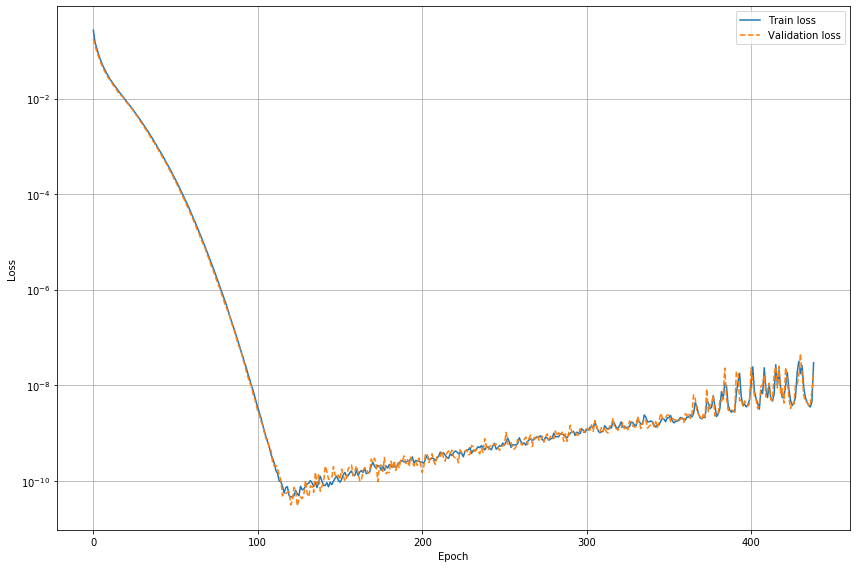

In [18]:
# Plot losses
plt.close('all')
plt.figure(figsize=(12,8))

plt.semilogy(train_loss_epochs, label='Train loss')
plt.semilogy(val_loss_epochs, label='Validation loss', linestyle='dashed')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(images_path+f"/model_losses_{crop_len}_{min_len}"+"_{}_{}_bible.png".format(params['lr'],params['wd']))
plt.show()